In [1]:
# This document/.ipynb file was originaly created by Sacha Dubrulle in Python 2 
# and further worked upon and converted to Python 3 by Thomas Valcke.
# This notebook has been converted to Python 3 because the syntax changed with Python 3.
# In this notebook a lot of files are required to make everything work but this file Runs 100% localy.
# When run on the server there was 1 Cell that did not work 
# ==> filtered_df.select("tweet_id_str").repartition(14*14).write.parquet("D:/School/STAGE_BP/ipo/final_filter_batch.parquet", mode = "overwrite")
# The reason for this cell not working is still unkown.

In [2]:
# from py4j.java_gateway import JavaGateway, GatewayParameters
# gateway = JavaGateway(gateway_parameters=GatewayParameters(port=25333))

# The code above was used to fix an error but sometimes the errors can be misleading and the gateway error was a triggerd by the Out of memmory error...

# <span style = 'color:darkred'> Notebook structure </span style>

- ### <a href=#imports> Imports & settings </a>
- ### <a href=#read_in> Reading in all tweets </a>
- ### <a href=#time_distr> Distribution over time </a>
- ### <a href=#filter> Filter for relevant tweets </a>

# <span style = 'color:darkred'> Imports & notebook settings </span style> <a name='imports' />

In [3]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# Python imports
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
import glob
import numpy as np

import pandas as pd

# Spark imports
from pyspark.sql.functions import udf, year, month, dayofmonth, explode, lower, regexp_extract, split, upper
from pyspark.sql.types import *
import time
import datetime
import pyspark

from pyspark.sql import SQLContext, SparkSession

try:
    sc = pyspark.SparkContext(appName = 'App')
    spark = SparkSession(sparkContext=sc)
    print("SparkSession initialized")
except ValueError:
    print("SparkSession already initialized")

SparkSession initialized


In [5]:

colors = {"orange": np.array([255,128,14], dtype = np.float16),
          "blue": np.array([0,107,164], dtype = np.float16),
          "green": np.array([44, 160, 44], dtype = np.float16)
         }

for k in list(colors.keys()):
    colors[k] = np.divide(colors[k], 255)

# <span style = 'color:darkred'> Reading in tweets </span style> <a name='read_in'/>

In [6]:
#(spark.read.json("/mnt/bdata1/twitter/archief/ipo/tweets/*.json")) Or the bdata4 location
df = (spark.read.json("D:/School/STAGE_BP/testSCP/tweets/201603*.json"))# .StorageLevel(True, True, False, False, 1) ## just trying to change storage level.
 
original_columns = df.columns
df = (df.withColumnRenamed("id_str", "tweet_id_str") #rename to avoid confusion with user_id, retweet_id, ...
        .withColumn("user_id_str", df.user.id_str) 
    )

print("The original columns were: {}".format(original_columns))


The original columns were: ['contributors', 'coordinates', 'created_at', 'entities', 'extended_entities', 'favorite_count', 'favorited', 'filter_level', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweet_count', 'retweeted', 'retweeted_status', 'scopes', 'source', 'text', 'timestamp_ms', 'truncated', 'user', 'withheld_in_countries']


In [7]:
df.count()


116400

# <span style = 'color:darkred'> Distribution over time </span style> <a name='time_distr'/>

In [8]:
# user defined function to strip date from created_at field, which originally is a string representation of datetime
udf_strip_pattern = udf(lambda string: (datetime.datetime.strptime(string, "%a %b %d %H:%M:%S +0000 %Y")).date(), DateType())

# create dataframe containing only a data per tweet
tweetcount_per_date = df.select(udf_strip_pattern("created_at").alias("date")).groupBy("date").count()

# cast dataframe to pandas for plotting
counts_pandas = tweetcount_per_date.toPandas()

# insert missing dates with a count equal to 0 to have them appearing in the plot as well
first_date = min(counts_pandas["date"])
last_date = max(counts_pandas["date"])
print("The data ranges from {} until {}".format(first_date, last_date))
dates_list = counts_pandas["date"].tolist()
missing_dates_and_counts = []
for i in dates_list:
    if i < last_date and i + datetime.timedelta(days = 1) not in dates_list:
        #print "Missing date: {}".format(i + datetime.timedelta(days = 1 ))
        dates_list.append(i + datetime.timedelta(days = 1))
        missing_dates_and_counts.append([i + datetime.timedelta(days = 1 ), 0])
print("There are {} missing dates".format(len(missing_dates_and_counts)))
missing_pandas = pd.DataFrame(missing_dates_and_counts, columns = ["date", "count"])

# concatenate available and missing data to one pandas dataframe for plotting
full_counts_per_date = pd.concat([counts_pandas, missing_pandas], axis = 0).reset_index(drop = True).sort_values("date", ascending = True)


The data ranges from 2016-03-30 until 2016-03-31
There are 0 missing dates


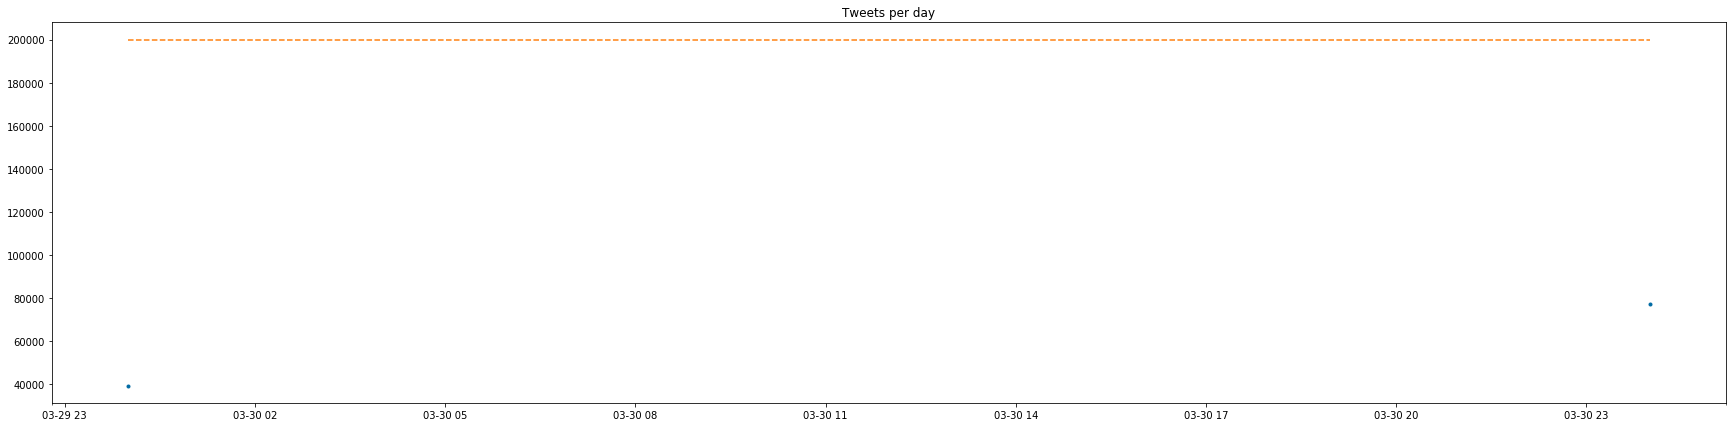

In [9]:
# plot tweet_count per date
fig = plt.figure(figsize = (30,7))
ax = fig.add_subplot(111)
ax.xaxis.set_minor_locator(MonthLocator())

plt.hlines(y = 200000, xmin = first_date, xmax = last_date, linestyles = "dashed", color = colors["orange"])
plt.title("Tweets per day")
plt.plot(full_counts_per_date["date"], full_counts_per_date["count"], ".", color = colors["blue"])



# <span style = 'color:darkred'> Filter for relevant tweets, i.e. related to IPOs </span style> <a name='filter'/>

In [10]:
with open("company_names.txt", "r") as f:
    companies_list = f.readlines()
    companies_list = [x.replace("\n", "").lower() for x in companies_list]

In [11]:
def contains_company_name(text_column):
    company_mentions = 0
    for i in companies_list:
        # strip spaces out of tweets
        if i in text_column.replace(" ", ""):
            company_mentions += 1
    return company_mentions

udf_contains_company_name = udf(contains_company_name, 
                                IntegerType())

In [12]:
# returns 0 if column is empty (no regexp match found), 1 otherwise (at least one regexp match found)
def non_empty_column(ipo_cashtag_column):
    if len(ipo_cashtag_column) > 0:
        return 1
    else:
        return 0

non_empty_column_udf = udf(non_empty_column)

# REGEX to extract tickers or presence of IPO
cashtag_expression = '\$[a-z]{1,6}'
ipo_expression = ' #ipo | ipo '

augmented_df = (df.select("tweet_id_str", "text", lower(df.text).alias("text_lower"))
                  .select("*", 
                           non_empty_column_udf(regexp_extract('text_lower', ipo_expression, 0)).alias("contains_ipo"),
                           non_empty_column_udf(regexp_extract('text_lower', cashtag_expression, 0)).alias("contains_cashtag"),
                           udf_contains_company_name("text_lower").alias("contains_company_name")
                          )
               )

filtered_df = augmented_df.filter((augmented_df.contains_ipo == 1) | 
                                  (augmented_df.contains_cashtag == 1) | 
                                  (augmented_df.contains_company_name == 1)
                                 )

In [13]:
#filtered_augmented_df.drop("text_lower").take(50)
filtered_df.drop("text_lower").take(50)

[Row(tweet_id_str='715590263599706112', text='Helpful tips for setting up your finance &amp; accounting\nfor success as a public company: https://t.co/YUu1mTRaAM #IPO https://t.co/ZssswxCPsg', contains_ipo='1', contains_cashtag='0', contains_company_name=0),
 Row(tweet_id_str='715590277298319360', text='#TexasValues in 2 Soldiers in their after-service book, Lessons Learned. Go Bold or Go Home  Listen: https://t.co/KAIZAv0yHP', contains_ipo='0', contains_cashtag='0', contains_company_name=1),
 Row(tweet_id_str='715647680878350336', text="RT @CraziestSex: idc if we haven't spoken in a while if you text me bc you need advice or simply a friend to talk to, I'll be here. I'm jus…", contains_ipo='0', contains_cashtag='0', contains_company_name=1),
 Row(tweet_id_str='715647697156329472', text='RT @VIZIO: Introducing the 2016 VIZIO SmartCast™ P-Series with @GoogleCast built-in &amp; 6” Tablet Remote. https://t.co/FhOeRu3DYD https://t.c…', contains_ipo='0', contains_cashtag='0', contains_compa

In [14]:
#filtered_augmented_df.select("tweet_id_str").repartition(14*14).write.parquet("final_filter_batch.parquet", mode = "overwrite")
filtered_df.select("tweet_id_str").repartition(14*14).write.parquet("D:/School/STAGE_BP/ipo/final_filter_batch.parquet", mode = "overwrite")